# Convolutional Variational Autoencoder

###### title Licensed under the Apache License, Version 2.0 (the "License");

This notebook is based on the tensorflow tutorial that you can find here : 
https://www.tensorflow.org/tutorials/generative/cvae

## Import TensorFlow and other libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import os, random
import time
import numpy as np
import glob
import pathlib
import matplotlib.pyplot as plt
import PIL
import imageio
import warnings
warnings.filterwarnings('ignore')

from IPython import display

## Load dataset

In [4]:
IMAGE_SIZE = 227,227
label_names = {0:'Negative', 1:'Positive'}

In [5]:
def load_dataset(data_root="../data/"):
    data_root = pathlib.Path(data_root)
    list_ds = tf.data.Dataset.list_files(str(data_root/'*.jpg'))
    
    SIZE = len(list(list_ds))
    #labeled_ds = list_ds.map(process_path)
      
    return list_ds, SIZE

In [6]:
# read the numpy files 
x_train = np.load('../data/data-images.npy') # run data producer to create npy files
y_train = np.load('../data/data-labels.npy') # run data producer to create npy files

FileNotFoundError: [Errno 2] No such file or directory: '../data/data-images.npy'

In [5]:
# PARAMETERS
TRAIN_BUF = len(x_train)
BATCH_SIZE = 64
NUM_CAT = 2
IMAGE_SIZE = 64


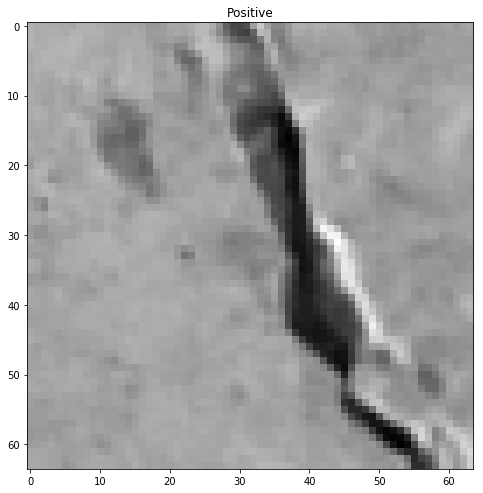

In [44]:
x_train_pos = x_train[y_train==1]
images = []
images.append(random.choice(x_train_pos))

ix = 0
fig = plt.figure(figsize=(8, 12))

for image in images :
    ix+=1    
    plt.imshow(image[:,:,0], cmap="gray")
    plt.title(label_names[1])



In [7]:
# plot a batch of images 
def show_batch(image_batch):
    plt.figure(figsize=(20,20))
    for n in range(64):
        
        ax = plt.subplot(8,8,n+1)
        plt.imshow(image_batch[n][:,:,0], cmap='gray')
        plt.title(label_names[1].title())
        plt.axis('off')


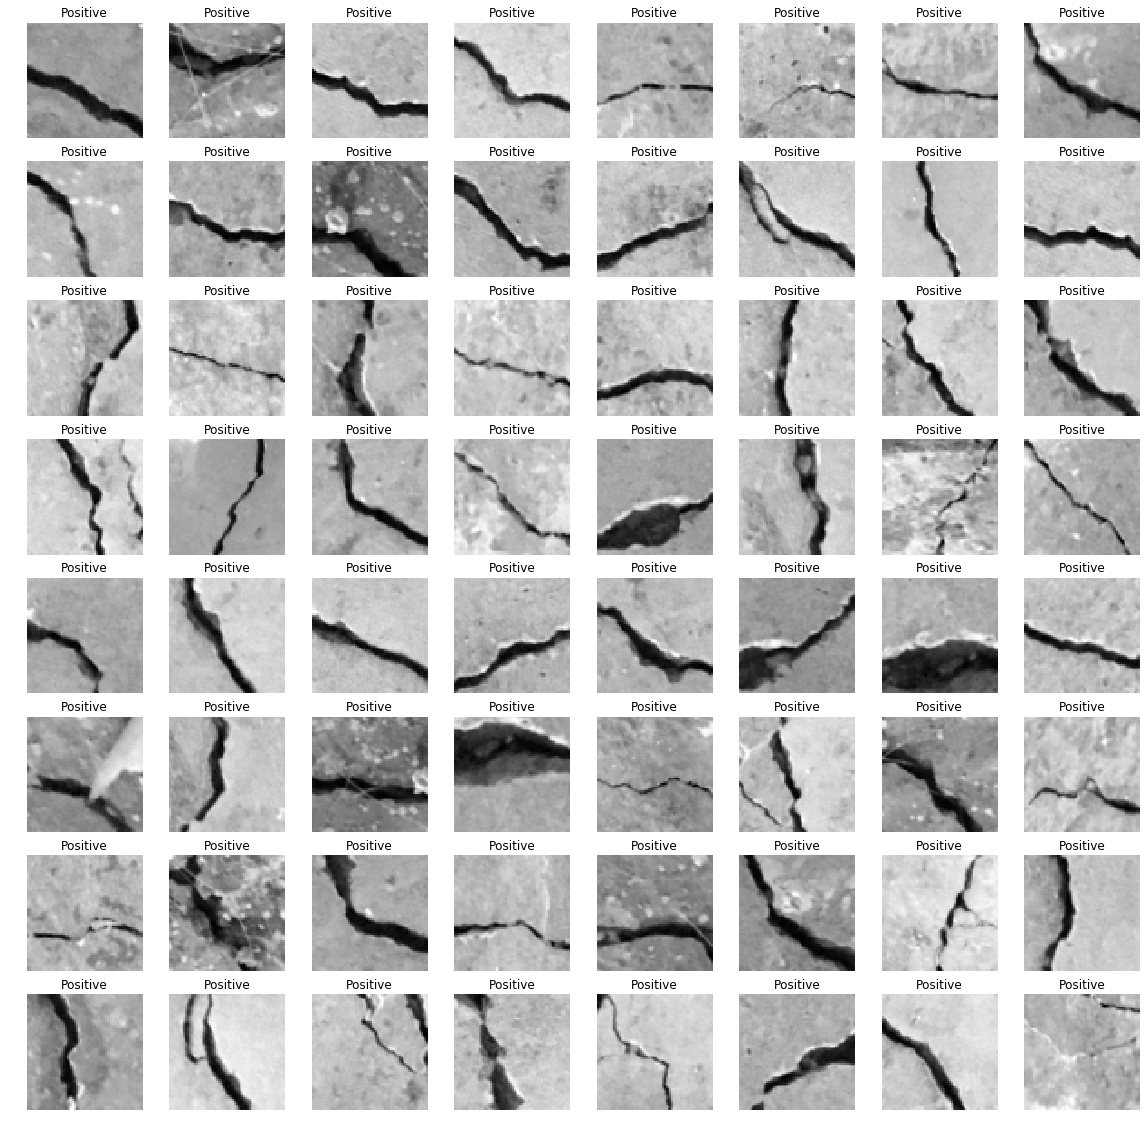

In [8]:
show_batch(x_train_pos)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [9]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
latent_dim = 500


In [10]:
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

### Encoder :

In [11]:
tf.keras.backend.clear_session()

def encoder(INPUT_SHAPE, latent_dim):

    inference_net = tf.keras.Sequential()

    inference_net.add(Conv2D(16, (2, 2), activation='relu', input_shape=INPUT_SHAPE, 
                             kernel_initializer='he_uniform', activity_regularizer=l1_l2(l1=0.01, l2=0.01)) )
    inference_net.add(BatchNormalization())
    inference_net.add(Conv2D(16, (3,3), activation='relu', 
                             kernel_initializer='he_uniform', activity_regularizer=l1_l2(l1=0.01, l2=0.01)) )
    inference_net.add(MaxPooling2D((2, 2)))

    inference_net.add(BatchNormalization())
    inference_net.add(Conv2D(32, (3,3), activation='relu',
                            kernel_initializer='he_uniform', activity_regularizer=l1_l2(l1=0.01, l2=0.01)) )
    inference_net.add(MaxPooling2D((2, 2)))

    inference_net.add(Conv2D(64, (3,3), activation='relu',
                            kernel_initializer='he_uniform', activity_regularizer=l1_l2(l1=0.01, l2=0.01)) )
    inference_net.add(MaxPooling2D((2, 2)))
    inference_net.add(BatchNormalization())

    inference_net.add(BatchNormalization())

    inference_net.add(MaxPooling2D((2, 2)))


    inference_net.add(tf.keras.layers.Flatten())
    # No activation
    inference_net.add(tf.keras.layers.Dense(latent_dim + latent_dim))
    return inference_net

inference_net = encoder(INPUT_SHAPE, latent_dim)
inference_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 16)        80        
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0

### Decoder :

In [12]:
def decoder(latent_dim):
    generative_net = tf.keras.Sequential()
    generative_net.add(tf.keras.layers.InputLayer(input_shape=(latent_dim,)))
    generative_net.add(tf.keras.layers.Dense(units=4*4*64, activation=tf.nn.relu))
    generative_net.add(tf.keras.layers.Reshape(target_shape=(4, 4, 64)))
    generative_net.add(tf.keras.layers.Conv2DTranspose(
      filters=64,
      kernel_size=(3,3),
      strides=(2, 2),
      padding="SAME",
      activation='relu'))
    
    generative_net.add(tf.keras.layers.Conv2DTranspose(
      filters=32,
      kernel_size=(3,3),
      strides=(2, 2),
      padding="SAME",
      activation='relu'))
    
    generative_net.add(tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=(3,3),
      strides=(2, 2),
      padding="SAME",
      activation='relu'))
    generative_net.add(tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=(3,3),
      strides=(2, 2),
      padding="SAME",
      activation='relu'))
    # No activation
    generative_net.add(tf.keras.layers.Conv2DTranspose(
      filters=1, kernel_size=(3,3), strides=(1, 1), padding="SAME"))
    return generative_net
generative_net = decoder(latent_dim)
generative_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              513024    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 1)        

In [13]:
tf.keras.backend.clear_session()

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = encoder(INPUT_SHAPE, latent_dim)
        self.generative_net = decoder(latent_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [15]:
epochs = 1500
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [16]:
def generate_and_save_images(model, epoch, test_input, path=''):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots

    path = "{}/image_at_epoch_{:04d}.png".format(path,epoch)
    plt.savefig(path)
    plt.show()

In [17]:
batch_zise = 32
STEP_SIZE = len(x_train_pos)//batch_zise 


## normalize pixel values and shuffle the dataset

In [18]:
np.random.shuffle(x_train_pos)
preprocessing = lambda image : (image - np.min(image))/np.ptp(image)

In [19]:
x_train_pos = preprocessing(x_train_pos)
x_train_pos.min(),x_train_pos.max(), x_train_pos.mean(), x_train_pos.std()

(0.0, 1.0, 0.49760664, 0.10895654)

In [20]:
import datetime
now_str = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
path = '../output/cvae/{}'.format(now_str)


if not os.path.exists(path):
    os.makedirs(path)


Epoch: 1500/1500, Test set ELBO: -2783.61083984375, time elapse for current epoch 1.1213796138763428


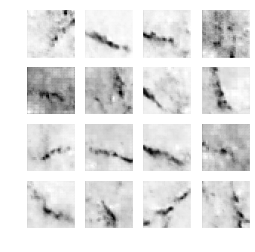

In [21]:
generate_and_save_images(model, 0, random_vector_for_generation, path=path)
training_loss =[]
STEP_SIZE = len(x_train_pos)//batch_zise

for epoch in range(1, epochs + 1):
    np.random.shuffle(x_train_pos) # shuffle the training data 
    start_time = time.time()
    for train_x in np.array_split(x_train_pos,STEP_SIZE): # split data to batchs 
        np.random.shuffle(train_x) # shuffle the batch
        compute_apply_gradients(model, train_x, optimizer) 
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in np.array_split(x_train_pos,STEP_SIZE):
            loss(compute_loss(model, test_x)) # compute ELBO loss
        elbo = -loss.result()
        training_loss.append(elbo)
        display.clear_output(wait=False)
        print('Epoch: {}/{}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,epochs,
                                                        elbo,
                                                        end_time - start_time))
        generate_and_save_images(
            model, epoch, random_vector_for_generation, path=path)

In [22]:
training_loss_list = [abs(x.numpy()) for x in training_loss]

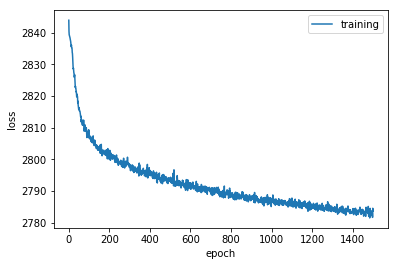

In [25]:
# plot the learning curve - ELBO loss 
%matplotlib inline

epoch_nums = range(1,len(training_loss_list)+1)
plt.plot(epoch_nums, training_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training'], loc='upper right')
plt.show()

### Display an image using the epoch number

In [26]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

### Generate new sampled images

In [27]:
def generate_and_save_images_(model, num_examples_to_generate=16, path='../data/output', latent_dim=100):
    random_vector_for_generation = tf.random.normal(
                                    shape=[num_examples_to_generate, latent_dim])
    
    generated_images = model.sample(random_vector_for_generation)
    if not os.path.exists(path):
        os.makedirs(path)

    
    for i in range(num_examples_to_generate):
        file_path = "{}/image_{}.jpg".format(path,i)
        imageio.imwrite(file_path, generated_images[i, :, :, 0]*255)
        # tight_layout minimizes the overlap between 2 sub-plots
        

In [7]:
generate_and_save_images_(model,10000,path=path+"/generated", latent_dim=latent_dim)

## Generate a GIF of all the saved images.

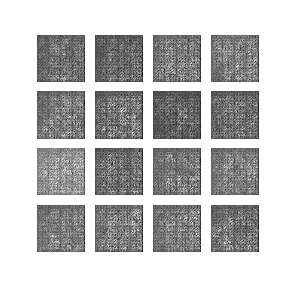

In [43]:
anim_file = os.path.join(path,'cvae.gif')
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(path+'/*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)

2018 – Özgenel, Ç.F., Gönenç Sorguç, A. “Performance Comparison of Pretrained Convolutional Neural Networks on Crack Detection in Buildings”, ISARC 2018, Berlin.

Lei Zhang , Fan Yang , Yimin Daniel Zhang, and Y. J. Z., Zhang, L., Yang, F., Zhang, Y. D., & Zhu, Y. J. (2016). Road Crack Detection Using Deep Convolutional Neural Network. In 2016 IEEE International Conference on Image Processing (ICIP). http://doi.org/10.1109/ICIP.2016.7533052